In [3]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='ticks', font='CMU Serif',
        rc={'font.size':12, 'mathtext.fontset': 'cm'})

In [4]:
class Inputs():
    def __init__(self, deltaP, maxSamples, seed=0):
        self.deltaP = deltaP
        self.maxSamples = maxSamples
        self.winning = None
        self.pA = None
        self.pB = None
        self.dP_actual = None
        self.As = [0]
        self.Bs = [0]
        self.rng = np.random.RandomState(seed=seed)
    def set_AB(self):
        self.winning = "A" if self.rng.rand()<0.5 else "B"
        highs = np.arange(0.1+self.deltaP, 0.9, 0.1)
        high = highs[self.rng.randint(len(highs))]
        low = high - self.deltaP
        nUpWin = int(high*self.maxSamples)
        nUpLose = int(low*self.maxSamples)
        self.As = np.zeros((self.maxSamples))
        self.Bs = np.zeros((self.maxSamples))
        if self.winning=="A":
            self.As[:nUpWin] = 1
            self.As[nUpWin:] = -1
            self.Bs[:nUpLose] = 1
            self.Bs[nUpLose:] = -1
            self.pA = nUpWin / self.maxSamples
            self.pB = nUpLose / self.maxSamples
        else:
            self.Bs[:nUpWin] = 1
            self.Bs[nUpWin:] = -1
            self.As[:nUpLose] = 1
            self.As[nUpLose:] = -1
            self.pB = nUpWin / self.maxSamples
            self.pA = nUpLose / self.maxSamples
        self.rng.shuffle(self.As)
        self.rng.shuffle(self.Bs)
        self.dP_actual = np.abs(self.pA - self.pB)
    def get_AB(self, t):
        AB = [self.As[int(t)], self.Bs[int(t)]] if t<self.maxSamples else [0,0]
        AB = [AB[0], 0] if t%1.0<0.5 else [0, AB[1]]  # A presented for 500ms, then B presented for 500ms
        return AB

In [5]:
def build_network(inputs, nNeurons=1000, tau=0.1, seed=0,
        w_time=0, w_ramp=0.2, w_delta=0, T=0.3, S=[0,0]):
    
    net = nengo.Network(seed=seed)
    net.config[nengo.Connection].synapse = 0.03
    net.config[nengo.Probe].synapse = 0.03
    
    func_evidence = lambda t: inputs.get_AB(t)
    func_thr = lambda t: T
    func_start = lambda t: S if t<1 else [0,0]
    func_urgency = lambda t: -w_time * t
    func_ramp = lambda x: tau * w_ramp * x
    func_uncertainty = lambda x: -w_delta * np.abs(x[0]-x[1])
    func_greater = lambda x: [x[0]-x[1], x[1]-x[0]] 
    
    ePos = nengo.dists.Choice([[1]])
    iPos = nengo.dists.Uniform(0.01, 1)
    dInh = -1e1*np.ones((2*nNeurons, 1))

    with net:
        # Inputs
        evidence = nengo.Node(func_evidence)
        time = nengo.Node(func_urgency)
        thr = nengo.Node(func_thr)
        start = nengo.Node(func_start)
        
        # Ensembles
        value = nengo.networks.EnsembleArray(nNeurons, 2)
        accumulate = nengo.networks.EnsembleArray(nNeurons, 2)
        combined = nengo.Ensemble(2*nNeurons, 2)
        gate = nengo.Ensemble(nNeurons, 1, encoders=ePos, intercepts=iPos)
        action = nengo.networks.EnsembleArray(nNeurons, 2, encoders=ePos, intercepts=iPos)
        
        # Connections
        nengo.Connection(evidence, value.input)
        nengo.Connection(start[0], accumulate.ea_ensembles[0], synapse=tau, function=func_ramp)
        nengo.Connection(start[1], accumulate.ea_ensembles[1], synapse=tau, function=func_ramp)
        nengo.Connection(value.ea_ensembles[0], accumulate.ea_ensembles[0], synapse=tau, function=func_ramp)
        nengo.Connection(value.ea_ensembles[1], accumulate.ea_ensembles[1], synapse=tau, function=func_ramp)
        nengo.Connection(accumulate.output, accumulate.input, synapse=tau)
        nengo.Connection(accumulate.output, combined)
        nengo.Connection(combined, gate, function=func_uncertainty)
        nengo.Connection(combined, action.input, function=func_greater)
        nengo.Connection(time, gate)
        nengo.Connection(thr, gate)
        nengo.Connection(gate, action.input, transform=[[-1], [-1]])

        # Probes
        net.pEvidence = nengo.Probe(evidence)
        net.pValue = nengo.Probe(value.output)
        net.pAccumulate = nengo.Probe(accumulate.output)
        net.pGate = nengo.Probe(gate)
        net.pAction = nengo.Probe(action.output)
        
        # references
        net.w_ramp = w_ramp
        net.w_delta = w_delta
        
    return net

In [6]:
def is_correct(inputs, net, sim, dt=0.001, action_threshold=0.0):
    chooseA = np.argwhere(sim.data[net.pAction][:,0] > action_threshold)
    chooseB = np.argwhere(sim.data[net.pAction][:,1] > action_threshold)
    timeA = chooseA[0][0]*dt if len(chooseA)>0 else sim.trange()[-1]
    timeB = chooseB[0][0]*dt if len(chooseB)>0 else sim.trange()[-1]
    if inputs.winning=="A":
        if timeA == timeB:  # forced response
            correct = True if sim.data[net.pAccumulate][-1][0] > sim.data[net.pAccumulate][-1][1] else False
            time = timeA
        elif timeA < timeB:
            correct = True
            time = timeA
        elif timeB < timeA:
            correct = False
            time = timeB
    elif inputs.winning=="B":
        if timeB == timeA:  # forced response
            correct = True if sim.data[net.pAccumulate][-1][1] > sim.data[net.pAccumulate][-1][0] else False
            time = timeB
        elif timeB < timeA:
            correct = True
            time = timeB
        elif timeA < timeB:
            correct = False
            time = timeA
    return correct, int(np.ceil(2*time)), time

In [11]:
def run_once(deltaP, maxSamples, seed, dt=0.001, legend=False, name="default", **kwargs):
    inputs = Inputs(deltaP=deltaP, maxSamples=maxSamples, seed=seed)
    inputs.set_AB()
    net = build_network(inputs, seed=seed, **kwargs)
    sim = nengo.Simulator(net, progress_bar=False)
    with sim:
        sim.run(maxSamples, progress_bar=True)

    idealA = np.cumsum(sim.data[net.pEvidence][:,0]) * net.w_ramp * dt
    idealB = np.cumsum(sim.data[net.pEvidence][:,1]) * net.w_ramp * dt
    ymin = np.around(np.min(np.concatenate((idealA, idealB))), 1)
    ymax = np.around(np.max(np.concatenate((idealA, idealB))), 1)
    y2a = np.around(np.max(np.abs(sim.data[net.pAccumulate][:,0]-sim.data[net.pAccumulate][:,1])), 1)
    y2b = np.around(np.max(sim.data[net.pGate]), 1)
    y2c = max(y2a, y2b)
    correct, cues, time = is_correct(inputs, net, sim)
    title = f"{'correct' if correct else 'incorrect'}, cues={cues:.0f} (" + r"$\Delta P" + f"={deltaP}" +r"$)"

#     fig, axes = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=((6.38, 3)))
    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=((9, 3)))
    axes[0].plot(sim.trange(), idealA, linestyle="--", color=palette[0])  # label="ideal A",
    axes[0].plot(sim.trange(), idealB, linestyle="--", color=palette[1])  # label="ideal B",
    axes[0].plot(0, 0, linestyle="--", color='k', label="ground truth")
    axes[0].plot(sim.trange(), sim.data[net.pAccumulate][:,0], color=palette[0])  # label="value A", 
    axes[0].plot(sim.trange(), sim.data[net.pAccumulate][:,1], color=palette[1])  # label="value B", 
    axes[0].plot(0, 0, color='k', label='model estimate') 
    axes[0].scatter(0, 0, color=palette[0], label='A') 
    axes[0].scatter(0, 0, color=palette[1], label='B') 
    axes[1].plot(sim.trange(), np.abs(sim.data[net.pAccumulate][:,0]-sim.data[net.pAccumulate][:,1]),
#                  label=r'$|\hat{\mathbf{x}}_0-\hat{\mathbf{x}}_1|$', color=palette[4])
                 label="evidence", color=palette[2])
    axes[1].plot(sim.trange(), sim.data[net.pGate], label='inhibition', color=palette[4])  # 
    axes[1].plot(sim.trange(), sim.data[net.pAction][:,0], label=r"A$\rightarrow$", color=palette[0])
    axes[1].plot(sim.trange(), sim.data[net.pAction][:,1], label=r"B$\rightarrow$", color=palette[1])
    axes[1].axvline(time, color='lime' if correct else 'red', lw=2)  # , label='decision time'
    axes[0].set(xlabel="cues", ylabel=r"$\mathbf{\hat{x}}(t)$", title="Total Value", yticks=((ymin, 0, ymax)),
                xlim=((0, maxSamples)), xticks=np.arange(0, maxSamples+1, 1), xticklabels=np.arange(0, 2*maxSamples+2, 2))
    axes[1].set(xlabel="cues", ylabel=None, title="Decision Criteria", yticks=((0, y2c)),
                xlim=((0, maxSamples)), xticks=np.arange(0, maxSamples+1, 1), xticklabels=np.arange(0, 2*maxSamples+2, 2))
    if legend:
        axes[0].legend(loc='upper left', ncol=1)
        axes[1].legend(loc='upper left', ncol=1)
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

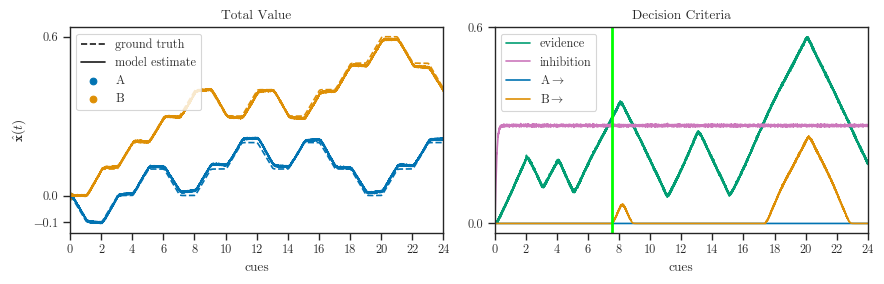

In [12]:
run_once(deltaP=0.1, maxSamples=12, seed=0, T=0.3, legend=True, name="dynamics1")

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

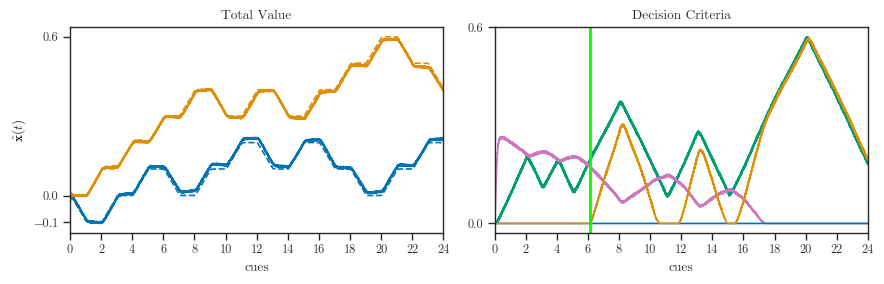

In [13]:
run_once(deltaP=0.1, maxSamples=12, seed=0, T=0.3, w_time=0.02, w_delta=0.4, name="dynamics2")

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

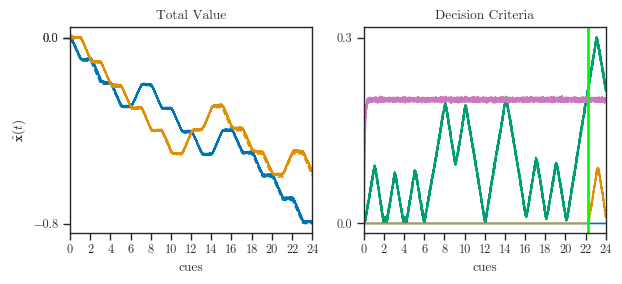

In [51]:
run_once(deltaP=0.1, maxSamples=12, seed=8, T=0.2)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

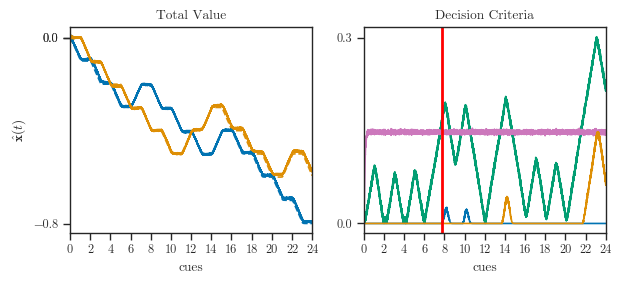

In [52]:
run_once(deltaP=0.1, maxSamples=12, seed=8, T=0.15)

In [61]:
def run_param_comparison(param, params, deltaP, maxSamples=12, seed=0,
        dt=0.001, legend=False, **kwargs):
    inputs = Inputs(deltaP=deltaP, maxSamples=maxSamples, seed=seed)
    inputs.set_AB()
    fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=((6.38, 3)))
    for i, p in enumerate(params):
        print(f"{param} = {p}")
        if param=="T":
            net = build_network(inputs, seed=seed, T=p, **kwargs)
            title = "decision threshold"
            ylabel = r"$T="+str(p)+"$"
        if param=="S":
            net = build_network(inputs, seed=seed, S=p, **kwargs)
            title = "starting evidence"
            ylabel = r"$S="+str(p)+"$"
        if param=="w_ramp":
            net = build_network(inputs, seed=seed, w_ramp=p, **kwargs)
            title = "ramp rate"
            ylabel = r"$w_{ramp}="+str(p)+"$"
        if param=="w_time":
            net = build_network(inputs, seed=seed, w_time=p, **kwargs)
            title = "temporal urgency"
            ylabel = r"$w_{time}="+str(p)+"$"
        if param=="w_delta":
            net = build_network(inputs, seed=seed, w_delta=p, **kwargs)
            title = "confidence"
            ylabel = r"$w_{delta}="+str(p)+"$"
        sim = nengo.Simulator(net, progress_bar=False)
        with sim:
            sim.run(maxSamples, progress_bar=False)

        idealA = np.cumsum(sim.data[net.pEvidence][:,0]) * net.w_ramp * dt
        idealB = np.cumsum(sim.data[net.pEvidence][:,1]) * net.w_ramp * dt
        ymin = np.around(np.min(np.concatenate((idealA, idealB))), 1)
        ymax = np.around(np.max(np.concatenate((idealA, idealB))), 1)
        y2a = np.around(np.max(np.abs(sim.data[net.pAccumulate][:,0]-sim.data[net.pAccumulate][:,1])), 1)
        y2b = np.around(np.max(sim.data[net.pGate]), 1)
        correct, cues, time = is_correct(inputs, net, sim)
        axes[i][0].plot(sim.trange(), idealA, label="ideal A", linestyle="--", color=palette[0])
        axes[i][0].plot(sim.trange(), idealB, label="ideal B", linestyle="--", color=palette[1])
        axes[i][0].plot(sim.trange(), sim.data[net.pAccumulate][:,0], label="evidence A", color=palette[0])
        axes[i][0].plot(sim.trange(), sim.data[net.pAccumulate][:,1], label="evidence B", color=palette[1])
        axes[i][1].plot(sim.trange(), sim.data[net.pAction][:,0], label="choose A", alpha=0.3, color=palette[0], zorder=0)
        axes[i][1].plot(sim.trange(), sim.data[net.pAction][:,1], label="choose B", alpha=0.3, color=palette[1], zorder=0)
        axes[i][1].plot(sim.trange(), sim.data[net.pGate], label='gate', color=palette[2])
        axes[i][1].plot(sim.trange(), np.abs(sim.data[net.pAccumulate][:,0]-sim.data[net.pAccumulate][:,1]), label='delta', color=palette[4])
        axes[i][1].scatter(time, 0, s=50, color='g' if correct else 'r', zorder=1, label='decision time')
        axes[i][0].set(ylabel=ylabel, yticks=((ymin, ymax)))
        axes[i][1].set(yticks=((0, y2a, y2b)))
    axes[0][0].set(title="Accumulated Evidence")
    axes[0][1].set(title="Decision Criteria")
    if legend:
        axes[0][0].legend(loc='upper right')
        axes[0][1].legend(loc='upper right')
    axes[2][0].set(xlabel="cues", xticks=np.arange(0, maxSamples+1, 1), xticklabels=np.arange(0, 2*maxSamples+2, 2))
    axes[2][1].set(xlabel="cues", xticks=np.arange(0, maxSamples+1, 1), xticklabels=np.arange(0, 2*maxSamples+2, 2))
    plt.tight_layout()
    fig.savefig(f"dynamics_{param}.svg")
    fig.savefig(f"dynamics_{param}.png", dpi=600)

T = 0.3
T = 0.2
T = 0.1


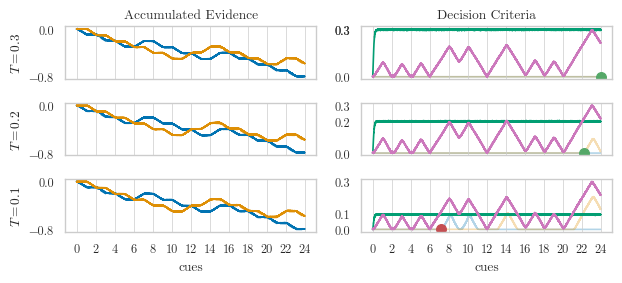

In [62]:
run_param_comparison("T", [0.3, 0.2, 0.1], deltaP=0.1, seed=8, legend=False)

w_time = 0.0
w_time = 0.02
w_time = 0.04


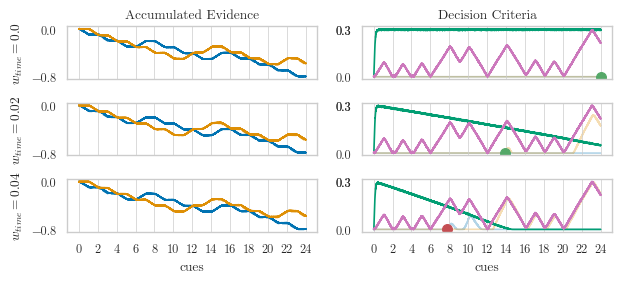

In [63]:
run_param_comparison("w_time", [0.0, 0.02, 0.04], deltaP=0.1, seed=8)

w_ramp = 0.1
w_ramp = 0.2
w_ramp = 0.3


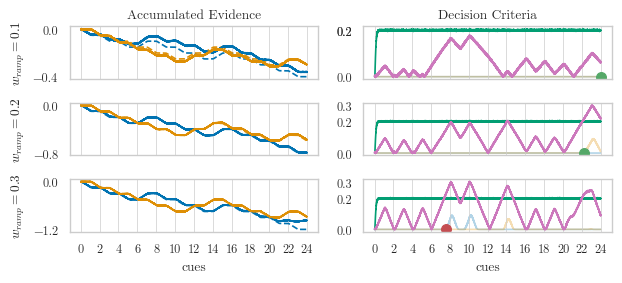

In [64]:
run_param_comparison("w_ramp", [0.1, 0.2, 0.3], T=0.2, deltaP=0.1, seed=8)

w_delta = 0.0
w_delta = 0.5
w_delta = 1.0


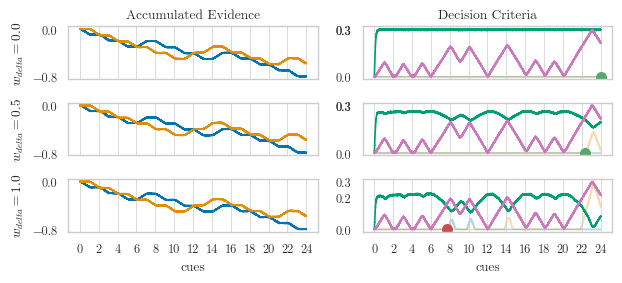

In [65]:
run_param_comparison("w_delta", [0.0, 0.5, 1.0], deltaP=0.1, seed=8)

In [10]:
def scan_parameter(scan, nNetworks, nTrials, deltaPs,
                   maxSamples=12, dt=0.001, low=0.1, high=0.3, load=False, **kwargs):
    if load:
        data = pd.read_pickle(f"data/scan_{scan}_nNetworks{nNetworks}_nTrials{nTrials}.pkl")
        collapsed_data = pd.read_pickle(f"data/scan_{scan}_nNetworks{nNetworks}_nTrials{nTrials}_collapsed.pkl")
    else:
        dfs = []
        columns = ('scan', 'param', 'seed', 'dP', 'trial', 'correct', 'cues')
        rng = np.random.RandomState(seed=nNetworks)
        params = np.linspace(low, high, nNetworks)
        for s in range(nNetworks):
            print(f"seed {s}")
            param = params[s]
            for dP in deltaPs:
                print(f"dP {dP}")
                inputs = Inputs(deltaP=dP, maxSamples=maxSamples, seed=s)
                for n in range(nTrials):
                    print(f"trial {n}")
                    inputs.set_AB()
                    if scan=="T":
                        net = build_network(inputs, seed=s, T=param, **kwargs)
                    elif scan=="w_ramp":
                        net = build_network(inputs, seed=s, w_ramp=param, **kwargs)
                    elif scan=="w_time":
                        net = build_network(inputs, seed=s, w_time=param, **kwargs)
                    elif scan=="w_delta":
                        net = build_network(inputs, seed=s, w_delta=param, **kwargs)
                    else:
                        raise
                    sim = nengo.Simulator(net, progress_bar=False)
                    with sim:
                        sim.run(maxSamples, progress_bar=False)
                    correct, cues, time = is_correct(inputs, net, sim)
                    dfs.append(pd.DataFrame([[scan, param, s, dP, n, correct, cues]], columns=columns))
        data = pd.concat(dfs, ignore_index=True)
        data.to_pickle(f"data/scan_{scan}_nNetworks{nNetworks}_nTrials{nTrials}.pkl")
        print(data)
        # collapse data by individual  (take mean of cues and accuracy)
        dfs = []
        columns = ('scan', 'param', 'seed', 'dP', 'mean correct', 'mean cues')
        for s in range(data['seed'].max()+1):
            for dP in data['dP'].unique():
                d = data.query("seed==@s and dP==@dP")
                dfs.append(pd.DataFrame([[
                    scan, d['param'].mean(), s, np.around(d['dP'].mean(),2), d['correct'].mean(), d['cues'].mean()
                    ]], columns=columns))
        collapsed_data = pd.concat(dfs, ignore_index=True)
        collapsed_data.to_pickle(f"data/scan_{scan}_nNetworks{nNetworks}_nTrials{nTrials}_collapsed.pkl")
    return(collapsed_data)

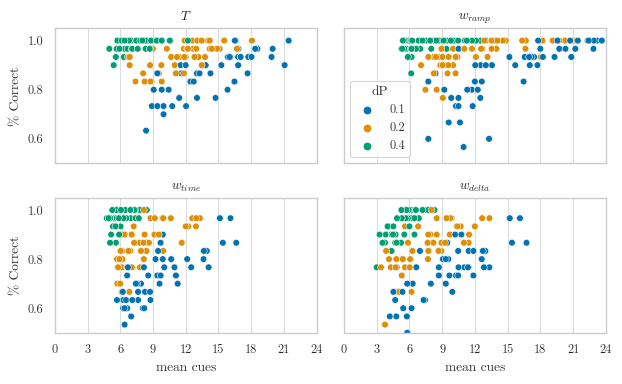

In [44]:
data_T = scan_parameter(scan="T", nNetworks=50, nTrials=30, deltaPs=[0.4, 0.2, 0.1], low=0.2, high=0.4, load=True)
data_w_ramp = scan_parameter(scan="w_ramp", nNetworks=50, nTrials=30, deltaPs=[0.4, 0.2, 0.1], low=0.1, high=0.3, load=True)
data_w_time = scan_parameter(scan="w_time", nNetworks=50, nTrials=30, deltaPs=[0.4, 0.2, 0.1], low=0.0, high=0.1, load=True)
data_w_delta = scan_parameter(scan="w_delta", nNetworks=50, nTrials=30, deltaPs=[0.4, 0.2, 0.1], low=0.0, high=1.0, load=True)

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=((6.38, 4)))
sns.scatterplot(data=data_T, x="mean cues", y="mean correct", hue='dP', ax=axes[0][0], palette=palette[:3])
sns.scatterplot(data=data_w_ramp, x="mean cues", y="mean correct", hue='dP', ax=axes[0][1], palette=palette[:3])
sns.scatterplot(data=data_w_time, x="mean cues", y="mean correct", hue='dP', ax=axes[1][0], palette=palette[:3])
sns.scatterplot(data=data_w_delta, x="mean cues", y="mean correct", hue='dP', ax=axes[1][1], palette=palette[:3])
axes[0][0].set(ylabel="% Correct", title=r"$T$")
axes[0][1].set(ylabel="% Correct", title=r"$w_{ramp}$")
axes[1][0].set(ylabel="% Correct", title=r"$w_{time}$")
axes[1][1].set(ylabel="% Correct", title=r"$w_{delta}$")
axes[0][0].get_legend().remove()
axes[1][0].get_legend().remove()
axes[1][1].get_legend().remove()
axes[0][0].set(ylim=((0.5, 1.05)))
axes[1][0].set(ylim=((0.5, 1.05)))
axes[1][0].set(xticks=np.arange(0, 27, 3), xlim=((0, 24)))
axes[1][1].set(xticks=np.arange(0, 27, 3), xlim=((0, 24)))
plt.tight_layout()

In [71]:
def SAT_simulated(nNetworks, nTrials, deltaPs=[0.4, 0.2, 0.1], load=False, **kwargs):
    if load:
        data = pd.read_pickle(f"data/SAT_simulated_nNetworks{nNetworks}_nTrials{nTrials}.pkl")
        collapsed_data = pd.read_pickle(f"data/SAT_simulated_nNetworks{nNetworks}_nTrials{nTrials}_collapsed.pkl")
    else:
        dfs = []
        columns = ('seed', 'T', 'w_ramp', 'w_time', 'w_delta', 'dP', 'trial', 'correct', 'cues')
        rng = np.random.RandomState(seed=nNetworks)
        for net in range(nNetworks):
            print(f"network {net}")
            seed = rng.randint(1, 10000)
            T = rng.uniform(0.2, 0.4)
            w_ramp = rng.uniform(0.1, 0.3)
            w_time = rng.uniform(0.01, 0.03)
            w_delta = rng.uniform(0.1, 0.3)
            for dP in deltaPs:
                print(f"dP {dP}")
                inputs = Inputs(deltaP=dP, maxSamples=12, seed=seed)
                net = build_network(inputs, seed=seed, T=T, w_ramp=w_ramp, w_time=w_time, w_delta=w_delta)
                for n in range(nTrials):
                    print(f"trial {n}")
                    inputs.set_AB()
                    sim = nengo.Simulator(net, progress_bar=False)
                    with sim:
                        sim.run(12, progress_bar=False)
                    correct, cues, time = is_correct(inputs, net, sim)
                    dfs.append(pd.DataFrame([[seed, T, w_ramp, w_time, w_delta, dP, n, correct, cues]], columns=columns))
        data = pd.concat(dfs, ignore_index=True)
        data.to_pickle(f"data/SAT_simulated_nNetworks{nNetworks}_nTrials{nTrials}.pkl")
        print(data)
        # collapse data by individual  (take mean of cues and accuracy)
        dfs = []
        columns = ('seed', 'T', 'w_ramp', 'w_time', 'w_delta', 'dP', 'mean correct', 'mean cues')
        for s in data['seed'].unique():
            for dP in data['dP'].unique():
                d = data.query("seed==@s and dP==@dP")
                dfs.append(pd.DataFrame([[
                    s,
                    d['T'].min(),
                    d['w_ramp'].min(),
                    d['w_time'].min(),
                    d['w_delta'].min(),
                    dP,
                    d['correct'].mean(),
                    d['cues'].mean()
                ]], columns=columns))
        collapsed_data = pd.concat(dfs, ignore_index=True)
        collapsed_data.to_pickle(f"data/SAT_simulated_nNetworks{nNetworks}_nTrials{nTrials}_collapsed.pkl")
        print(collapsed_data)

In [65]:
nNetworks = 30
nTrials = 30

SAT_simulated(nNetworks=nNetworks, nTrials=nTrials)

network 0
dP 0.4
trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9
trial 10
trial 11
trial 12
trial 13
trial 14
trial 15
trial 16
trial 17
trial 18
trial 19
trial 20
trial 21
trial 22
trial 23
trial 24
trial 25
trial 26
trial 27
trial 28
trial 29
dP 0.2
trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9
trial 10
trial 11
trial 12
trial 13
trial 14
trial 15
trial 16
trial 17
trial 18
trial 19
trial 20
trial 21
trial 22
trial 23
trial 24
trial 25
trial 26
trial 27
trial 28
trial 29
dP 0.1
trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9
trial 10
trial 11
trial 12
trial 13
trial 14
trial 15
trial 16
trial 17
trial 18
trial 19
trial 20
trial 21
trial 22
trial 23
trial 24
trial 25
trial 26
trial 27
trial 28
trial 29
network 1
dP 0.4
trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9
trial 10
trial 11
trial 12
trial 13
trial 14
trial 15
trial 16
trial 17
trial 18
trial 19
tr

trial 9
trial 10
trial 11
trial 12
trial 13
trial 14
trial 15
trial 16
trial 17
trial 18
trial 19
trial 20
trial 21
trial 22
trial 23
trial 24
trial 25
trial 26
trial 27
trial 28
trial 29
dP 0.2
trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9
trial 10
trial 11
trial 12
trial 13
trial 14
trial 15
trial 16
trial 17
trial 18
trial 19
trial 20
trial 21
trial 22
trial 23
trial 24
trial 25
trial 26
trial 27
trial 28
trial 29
dP 0.1
trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9
trial 10
trial 11
trial 12
trial 13
trial 14
trial 15
trial 16
trial 17
trial 18
trial 19
trial 20
trial 21
trial 22
trial 23
trial 24
trial 25
trial 26
trial 27
trial 28
trial 29
network 11
dP 0.4
trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9
trial 10
trial 11
trial 12
trial 13
trial 14
trial 15
trial 16
trial 17
trial 18
trial 19
trial 20
trial 21
trial 22
trial 23
trial 24
trial 25
trial 26
trial 27
trial 28
trial 29


trial 18
trial 19
trial 20
trial 21
trial 22
trial 23
trial 24
trial 25
trial 26
trial 27
trial 28
trial 29
dP 0.2
trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9
trial 10
trial 11
trial 12
trial 13
trial 14
trial 15
trial 16
trial 17
trial 18
trial 19
trial 20
trial 21
trial 22
trial 23
trial 24
trial 25
trial 26
trial 27
trial 28
trial 29
dP 0.1
trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9
trial 10
trial 11
trial 12
trial 13
trial 14
trial 15
trial 16
trial 17
trial 18
trial 19
trial 20
trial 21
trial 22
trial 23
trial 24
trial 25
trial 26
trial 27
trial 28
trial 29
network 21
dP 0.4
trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9
trial 10
trial 11
trial 12
trial 13
trial 14
trial 15
trial 16
trial 17
trial 18
trial 19
trial 20
trial 21
trial 22
trial 23
trial 24
trial 25
trial 26
trial 27
trial 28
trial 29
dP 0.2
trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
t

    seed         T    w_ramp    w_time   w_delta   dP  mean correct  mean cues
0   5926  0.383396  0.143651  0.046838  0.678756  0.4      0.866667   6.300000
1   5926  0.383396  0.143651  0.046838  0.678756  0.2      0.900000   6.700000
2   5926  0.383396  0.143651  0.046838  0.678756  0.1      0.600000   6.766667
3   4860  0.269332  0.298350  0.031155  0.627125  0.4      0.733333   3.133333
4   4860  0.269332  0.298350  0.031155  0.627125  0.2      0.666667   3.900000
..   ...       ...       ...       ...       ...  ...           ...        ...
85  1968  0.226152  0.239351  0.030707  0.187522  0.2      0.733333   4.533333
86  1968  0.226152  0.239351  0.030707  0.187522  0.1      0.500000   4.533333
87  7769  0.380051  0.158782  0.067432  0.810470  0.4      0.833333   4.233333
88  7769  0.380051  0.158782  0.067432  0.810470  0.2      0.833333   5.400000
89  7769  0.380051  0.158782  0.067432  0.810470  0.1      0.533333   5.266667

[90 rows x 8 columns]


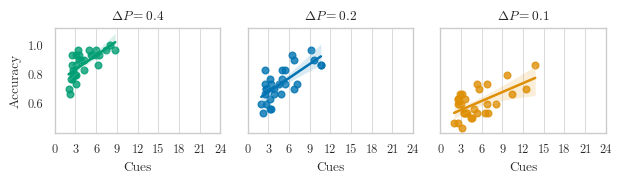

In [66]:
sim = pd.read_pickle(f"data/SAT_simulated_nNetworks{nNetworks}_nTrials{nTrials}_collapsed.pkl")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=((6.38, 2)), sharex=True, sharey=True)
sns.regplot(data=sim.query("dP==0.4"), x='mean cues', y='mean correct', color=palette[2], ax=axes[0])
sns.regplot(data=sim.query("dP==0.2"), x='mean cues', y='mean correct', color=palette[0], ax=axes[1])
sns.regplot(data=sim.query("dP==0.1"), x='mean cues', y='mean correct', color=palette[1], ax=axes[2])
axes[0].set(ylabel='Accuracy', xlabel='Cues', title=r'$\Delta P=0.4$')
axes[1].set(ylabel=None, xlabel='Cues', title=r'$\Delta P=0.2$')
axes[2].set(ylabel=None, xlabel='Cues', title=r'$\Delta P=0.1$', xticks=np.arange(0, 27, 3), xlim=((0, 24)))
plt.tight_layout()
fig.savefig(f"plots/SAT_simulated.svg")
fig.savefig(f"plots/SAT_simulated.png", dpi=600)

In [68]:
nNetworks = 20
nTrials = 5

SAT_simulated(nNetworks=nNetworks, nTrials=nTrials)

network 0
dP 0.4
trial 0
trial 1
trial 2
trial 3
trial 4
dP 0.2
trial 0
trial 1
trial 2
trial 3
trial 4
dP 0.1
trial 0
trial 1
trial 2
trial 3
trial 4
network 1
dP 0.4
trial 0
trial 1
trial 2
trial 3
trial 4
dP 0.2
trial 0
trial 1
trial 2
trial 3
trial 4
dP 0.1
trial 0
trial 1
trial 2
trial 3
trial 4
network 2
dP 0.4
trial 0
trial 1
trial 2
trial 3
trial 4
dP 0.2
trial 0
trial 1
trial 2
trial 3
trial 4
dP 0.1
trial 0
trial 1
trial 2
trial 3
trial 4
network 3
dP 0.4
trial 0
trial 1
trial 2
trial 3
trial 4
dP 0.2
trial 0
trial 1
trial 2
trial 3
trial 4
dP 0.1
trial 0
trial 1
trial 2
trial 3
trial 4
network 4
dP 0.4
trial 0
trial 1
trial 2
trial 3
trial 4
dP 0.2
trial 0
trial 1
trial 2
trial 3
trial 4
dP 0.1
trial 0
trial 1
trial 2
trial 3
trial 4
network 5
dP 0.4
trial 0
trial 1
trial 2
trial 3
trial 4
dP 0.2
trial 0
trial 1
trial 2
trial 3
trial 4
dP 0.1
trial 0
trial 1
trial 2
trial 3
trial 4
network 6
dP 0.4
trial 0
trial 1
trial 2
trial 3
trial 4
dP 0.2
trial 0
trial 1
trial 2
trial 

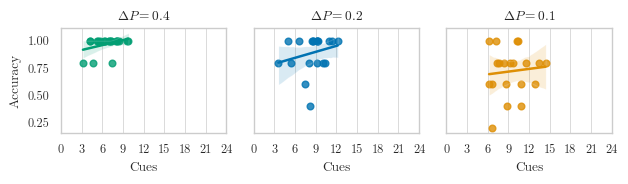

In [69]:
sim = pd.read_pickle(f"data/SAT_simulated_nNetworks{nNetworks}_nTrials{nTrials}_collapsed.pkl")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=((6.38, 2)), sharex=True, sharey=True)
sns.regplot(data=sim.query("dP==0.4"), x='mean cues', y='mean correct', color=palette[2], ax=axes[0])
sns.regplot(data=sim.query("dP==0.2"), x='mean cues', y='mean correct', color=palette[0], ax=axes[1])
sns.regplot(data=sim.query("dP==0.1"), x='mean cues', y='mean correct', color=palette[1], ax=axes[2])
axes[0].set(ylabel='Accuracy', xlabel='Cues', title=r'$\Delta P=0.4$')
axes[1].set(ylabel=None, xlabel='Cues', title=r'$\Delta P=0.2$')
axes[2].set(ylabel=None, xlabel='Cues', title=r'$\Delta P=0.1$', xticks=np.arange(0, 27, 3), xlim=((0, 24)))
plt.tight_layout()
fig.savefig(f"plots/SAT_simulated.svg")
fig.savefig(f"plots/SAT_simulated.png", dpi=600)

In [72]:
nNetworks = 10
nTrials = 30

SAT_simulated(nNetworks=nNetworks, nTrials=nTrials)

network 0
dP 0.4
trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9
trial 10
trial 11
trial 12
trial 13
trial 14
trial 15
trial 16
trial 17
trial 18
trial 19
trial 20
trial 21
trial 22
trial 23
trial 24
trial 25
trial 26
trial 27
trial 28
trial 29
dP 0.2
trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9
trial 10
trial 11
trial 12
trial 13
trial 14
trial 15
trial 16
trial 17
trial 18
trial 19
trial 20
trial 21
trial 22
trial 23
trial 24
trial 25
trial 26
trial 27
trial 28
trial 29
dP 0.1
trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9
trial 10
trial 11
trial 12
trial 13
trial 14
trial 15
trial 16
trial 17
trial 18
trial 19
trial 20
trial 21
trial 22
trial 23
trial 24
trial 25
trial 26
trial 27
trial 28
trial 29
network 1
dP 0.4
trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9
trial 10
trial 11
trial 12
trial 13
trial 14
trial 15
trial 16
trial 17
trial 18
trial 19
tr

/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 28
trial 29
dP 0.2
trial 0
trial 1


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9
trial 10
trial 11
trial 12
trial 13
trial 14
trial 15
trial 16
trial 17
trial 18
trial 19
trial 20
trial 21
trial 22
trial 23
trial 24
trial 25
trial 26
trial 27
trial 28
trial 29
dP 0.1
trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


trial 10


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


trial 11


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 12
trial 13


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


trial 14
trial 15


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


trial 16


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


trial 17
trial 18


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


trial 19


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 20
trial 21
trial 22
trial 23
trial 24
trial 25
trial 26
trial 27
trial 28
trial 29
network 8
dP 0.4
trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 8


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


trial 9


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


trial 10


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 11
trial 12
trial 13
trial 14
trial 15
trial 16
trial 17


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


trial 18
trial 19
trial 20
trial 21
trial 22
trial 23
trial 24
trial 25
trial 26
trial 27
trial 28
trial 29


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


dP 0.2
trial 0
trial 1


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 2


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 3
trial 4


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 5


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


trial 6


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 7
trial 8
trial 9
trial 10
trial 11
trial 12
trial 13
trial 14
trial 15
trial 16
trial 17
trial 18
trial 19
trial 20
trial 21
trial 22
trial 23
trial 24


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


trial 25


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


trial 26
trial 27


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 28


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 29


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


dP 0.1
trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 10


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 11
trial 12
trial 13
trial 14
trial 15
trial 16
trial 17
trial 18
trial 19
trial 20
trial 21
trial 22


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


trial 23


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 24
trial 25


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


trial 26


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


trial 27
trial 28


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 29


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


network 9
dP 0.4
trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9
trial 10
trial 11
trial 12


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 13


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 14
trial 15
trial 16
trial 17
trial 18
trial 19
trial 20
trial 21
trial 22
trial 23
trial 24
trial 25


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 26


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 27
trial 28


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 29


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


dP 0.2
trial 0


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9
trial 10
trial 11
trial 12
trial 13
trial 14


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 15
trial 16


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 17


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 18
trial 19
trial 20
trial 21
trial 22
trial 23
trial 24
trial 25
trial 26
trial 27
trial 28
trial 29
dP 0.1
trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9
trial 10
trial 11
trial 12
trial 13
trial 14
trial 15
trial 16
trial 17
trial 18
trial 19
trial 20
trial 21
trial 22
trial 23
trial 24
trial 25
trial 26
trial 27
trial 28
trial 29
     seed         T    w_ramp    w_time   w_delta   dP  trial  correct  cues
0    1290  0.259752  0.198918  0.018860  0.266382  0.4      0     True    12
1    1290  0.259752  0.198918  0.018860  0.266382  0.4      1     True     6
2    1290  0.259752  0.198918  0.018860  0.266382  0.4      2     True     3
3    1290  0.259752  0.198918  0.018860  0.266382  0.4      3    False     5
4    1290  0.259752  0.198918  0.018860  0.266382  0.4      4     True     6
..    ...       ...       ...       ...       ...  ...    ...      ...   ...
895  2053  0.270331  0.250930  0.015919  0.276787  0.1     25     True     8
896  2053

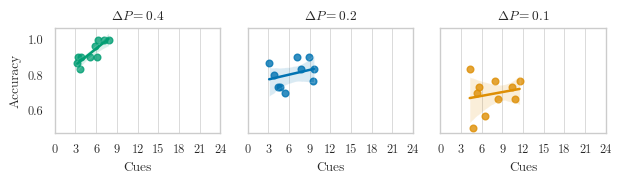

In [73]:
sim = pd.read_pickle(f"data/SAT_simulated_nNetworks{nNetworks}_nTrials{nTrials}_collapsed.pkl")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=((6.38, 2)), sharex=True, sharey=True)
sns.regplot(data=sim.query("dP==0.4"), x='mean cues', y='mean correct', color=palette[2], ax=axes[0])
sns.regplot(data=sim.query("dP==0.2"), x='mean cues', y='mean correct', color=palette[0], ax=axes[1])
sns.regplot(data=sim.query("dP==0.1"), x='mean cues', y='mean correct', color=palette[1], ax=axes[2])
axes[0].set(ylabel='Accuracy', xlabel='Cues', title=r'$\Delta P=0.4$')
axes[1].set(ylabel=None, xlabel='Cues', title=r'$\Delta P=0.2$')
axes[2].set(ylabel=None, xlabel='Cues', title=r'$\Delta P=0.1$', xticks=np.arange(0, 27, 3), xlim=((0, 24)))
plt.tight_layout()
fig.savefig(f"plots/SAT_simulated.svg")
fig.savefig(f"plots/SAT_simulated.png", dpi=600)